In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import numpy as np
import pandas as pd
import os
import sys
import librosa


parent = os.path.abspath(os.path.join('..'))
sys.path.append(parent)

In [2]:
def read_audio_file(file_path, sr=None):
    try:
        audio_data, sampling_rate = librosa.load(file_path, sr=sr)
        return audio_data, sampling_rate
    except Exception as e:
        print(f"Error reading audio file: {e}")
        return None, None


def downsample_audio(audio, original_sr, target_sr):
    return librosa.resample(audio, orig_sr=original_sr, target_sr=target_sr)


def audio_to_melspectrogram(audio, sampling_rate, hop_length=256, n_fft=2048):
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sampling_rate, hop_length=hop_length, n_fft=n_fft)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram


def cut_random_segment(audio, segment_size):
    max_start_time = max(0, len(audio) - segment_size)
    start_time = np.random.randint(0, max_start_time)
    return audio[start_time:(start_time + segment_size)]


def show_melspectrogram(spectrogram, sampling_rate, title='log-frequency power spectrogram'):
    librosa.display.specshow(spectrogram, x_axis='time', y_axis='mel', sr=sampling_rate)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()


def show_signal(audio):
    plt.plot(audio)
    plt.title('Signal')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.show()


def read_as_melspectrogram(file_path):
    audio, sampling_rate = read_audio_file(file_path)
    spectrogram = audio_to_melspectrogram(audio, sampling_rate)
    return spectrogram

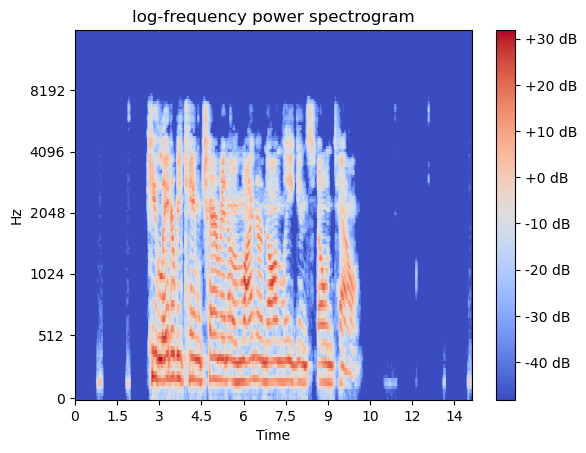

In [3]:
audio_path = '/home/klig/Datasets/cv-corpus-14.0-delta-2023-06-23/en/clips/common_voice_en_37285574.mp3'
audio, sampling_rate = read_audio_file(audio_path)
spectrogram = audio_to_melspectrogram(audio, sampling_rate, hop_length=256)
show_melspectrogram(spectrogram, sampling_rate)

In [4]:
from data.datasets import AudioLibary


root = '/home/klig/Datasets/cv-corpus-14.0-delta-2023-06-23/en/clips/'
sampling_rate = 8000
segment_size = 1024 * 8
max_size = 128


dataset = AudioLibary(root, sampling_rate, segment_size, max_size)
loader = torch.utils.data.DataLoader(dataset, batch_size=8)
batch = next(iter(loader))

In [5]:
batch['input'].size()

torch.Size([8, 1, 256, 257])

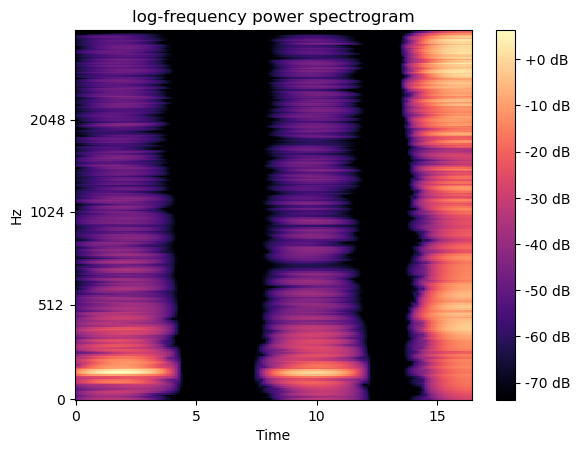

In [7]:
show_melspectrogram(batch['input'][0,0].numpy(), 8000)

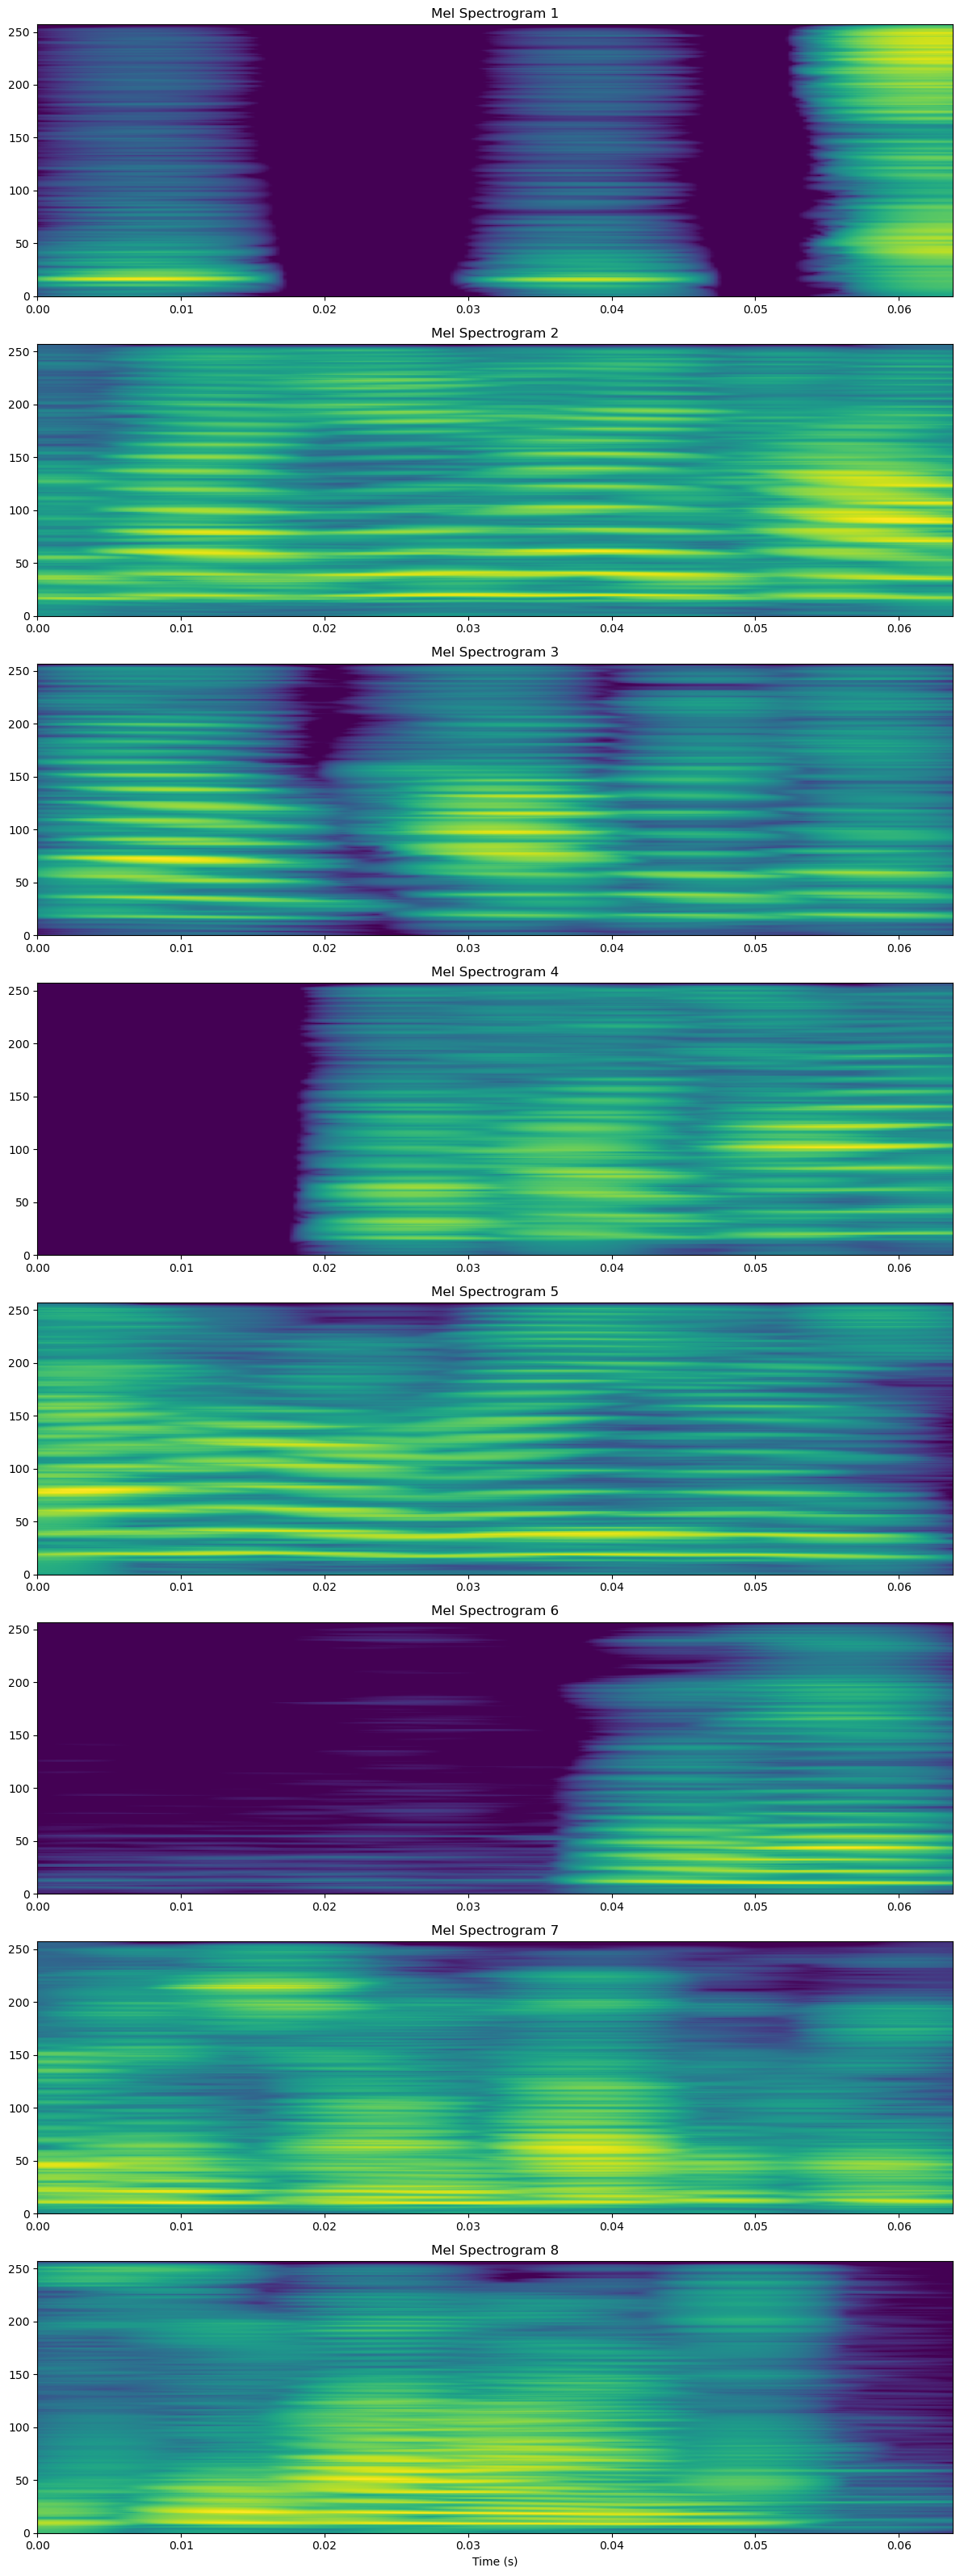

In [15]:
def plot_spectrograms(batch, sample_rate=8000, title=None):
    batch_size, num_channels, num_frames, num_mels = batch.shape

    assert num_channels == 1, "This function assumes single-channel mel spectrograms"

    time_axis = np.arange(0, num_frames) / (sample_rate / 2)

    plt.figure(figsize=(12, 4 * batch_size))
    for i in range(batch_size):
        plt.subplot(batch_size, 1, i + 1)
        plt.imshow(batch[i, 0], aspect='auto', origin='lower', cmap='viridis', extent=[0, time_axis[-1], 0, num_mels])
        plt.title(f'Spectrogram {i+1}')

    plt.xlabel('Time (s)')

    if title:
        plt.suptitle(title, y=0.92)

    plt.tight_layout()
    plt.show()


plot_spectrograms(batch['input'].numpy(), 8000)